# Using the Bambi with HSSM

Bambi is a high-level Bayesian model-building interface written in Python. It's built on top of the PyMC probabilistic programming framework, and is designed to make it extremely easy to fit mixed-effects models common in social sciences settings using a Bayesian approach.

Bambi gives a lot of freedom to customze 

In [3]:
import arviz as az
import bambi as bmb
import jax
import multiprocessing as mp
import numpy as np

import pandas as pd
import pymc as pm
from pymc import sampling_jax
import pytensor
import pytensor.tensor as pt

# WFPT and LAN are two factory classes
from hssm import wfpt
from hssm.wfpt import lan
import ssms.basic_simulators

## Using Base WFPT class 

In [3]:
WFPT_base = wfpt.WFPT

In [4]:
# Simulate some data
v_true, a_true, z_true, t_true = [0.5, 1.5, 0.5, 0.5]
obs_angle = ssms.basic_simulators.simulator(
    [v_true, a_true, z_true, t_true], model="ddm", n_samples=1000
)
obs = np.column_stack([obs_angle["rts"][:, 0], obs_angle["choices"][:, 0]])
obs

array([[ 2.43803453,  1.        ],
       [ 1.97901309,  1.        ],
       [ 2.72202134,  1.        ],
       ...,
       [ 5.24383879, -1.        ],
       [ 2.04201603,  1.        ],
       [ 1.20299459,  1.        ]])

### Bambi requires data to be in pandas format 

In [5]:
df_wfpt = pd.DataFrame(obs, columns=["rts", "choices"])

### Use Bambi to create an analytical solution of the WFPT likelihood function follows Navarro & Fuss (2009).

In [6]:
WFPTLikelihood = bmb.Likelihood(
    "WFPT", params=["v", "sv", "a", "z", "t"], parent="v", dist=WFPT_base
)
# You don't need to pass the link function for all the parameters when it's a non-distributional model.
# But if you want to use predictor for that parameter, you do need a link function
WFPTFamily = bmb.Family(
    "WFPT",
    likelihood=WFPTLikelihood,
    link={
        "v": "identity",
        "sv": "identity",
        "a": "identity",
        "z": "identity",
        "t": "identity",
    },
)
priors = {
    "Intercept": bmb.Prior("Uniform", lower=-3, upper=3),
    "sv": 0,
    "a": bmb.Prior("Uniform", lower=0.5, upper=2.0),
    "z": bmb.Prior("Uniform", lower=0.1, upper=0.9),
    "t": bmb.Prior("Uniform", lower=0.0, upper=2.0),
}

bmb_ddm = bmb.Model("c(rts,choices)  ~ 1", df_wfpt, family=WFPTFamily, priors=priors)
bmb_ddm

       Formula: c(rts,choices)  ~ 1
        Family: WFPT
          Link: v = identity
  Observations: 1000
        Priors: 
    target = v
        Common-level effects
            Intercept ~ Uniform(lower: -3.0, upper: 3.0)
        
        Auxiliary parameters
            c(rts, choices)_t ~ Uniform(lower: 0.0, upper: 2.0)
            c(rts, choices)_z ~ Uniform(lower: 0.1, upper: 0.9)
            c(rts, choices)_sv ~ 0
            c(rts, choices)_a ~ Uniform(lower: 0.5, upper: 2.0)

In [7]:
pytensor.config.floatX = "float32"

idata_bmb_ddm = bmb_ddm.fit(
    chains=2,
    draws=500,
    tune=500,
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [c(rts, choices)_t, c(rts, choices)_z, c(rts, choices)_a, Intercept]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 4 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [15]:
az.summary(idata_bmb_ddm)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"c(rts, choices)_a",1.540,0.027,1.491,1.592,0.001,0.001,654.0,710.0,1.01
"c(rts, choices)_z",0.491,0.012,0.471,0.516,0.001,0.000,544.0,645.0,1.00
"c(rts, choices)_t",0.492,0.021,0.453,0.532,0.001,0.001,602.0,568.0,1.01
Intercept,0.482,0.029,0.426,0.533,0.001,0.001,611.0,494.0,1.00


array([[<Axes: title={'center': 'c(rts, choices)_a'}>,
        <Axes: title={'center': 'c(rts, choices)_a'}>],
       [<Axes: title={'center': 'c(rts, choices)_z'}>,
        <Axes: title={'center': 'c(rts, choices)_z'}>],
       [<Axes: title={'center': 'c(rts, choices)_t'}>,
        <Axes: title={'center': 'c(rts, choices)_t'}>],
       [<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>]], dtype=object)

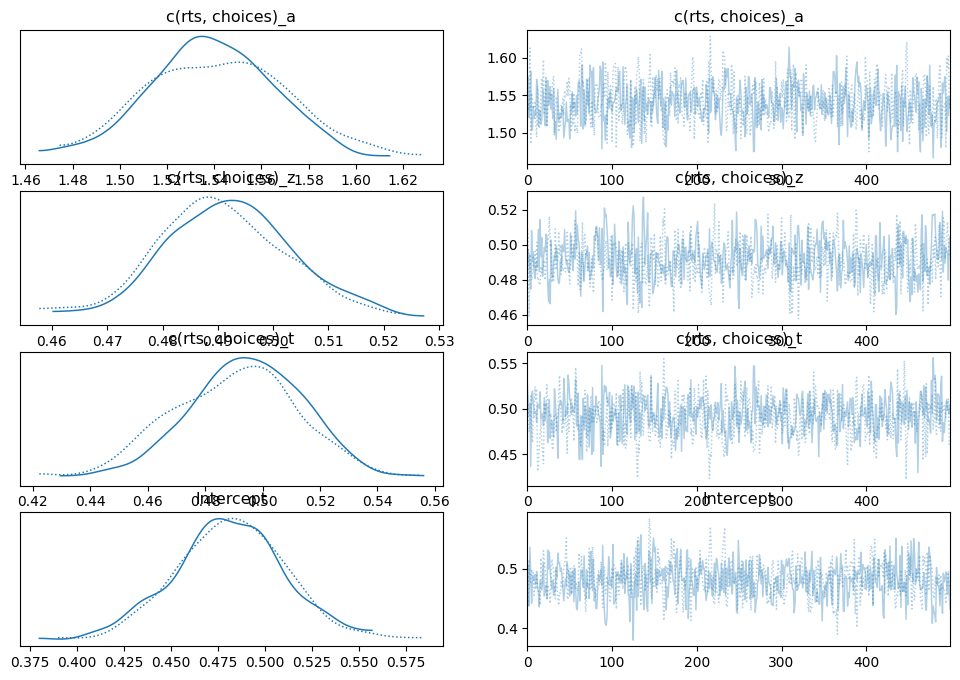

In [19]:
az.plot_trace(idata_bmb_ddm)

## Using the `LAN` factory class for LAN related functionalities

The LAN class has factory methods that produces LAN related log-likelihoods using either `aesara` or `jax` backend.


#### Create a LAN distribution directly from `WFPT.make_lan_distribution`

`WFPT.make_lan_distribution` conveniently wraps all steps above and create a `pymc.Distribution`.

In [14]:
# Simulate some data
v_true, a_true, z_true, t_true, theta_true = [0.5, 1.5, 0.5, 0.5, 0.3]
obs_angle_lan = ssms.basic_simulators.simulator(
    [v_true, a_true, z_true, t_true, theta_true], model="angle", n_samples=1000
)
obs_lan = np.column_stack([obs_angle_lan["rts"][:, 0], obs_angle_lan["choices"][:, 0]])
obs_lan

array([[ 1.07099628,  1.        ],
       [ 0.88099861, -1.        ],
       [ 1.60099542,  1.        ],
       ...,
       [ 1.88700879,  1.        ],
       [ 1.7290014 ,  1.        ],
       [ 1.47299099,  1.        ]])

In [15]:
df_lan = pd.DataFrame(obs_lan, columns=["rts", "choices"])

In [1]:
from huggingface_hub import hf_hub_download

ONNX_Model_Path = hf_hub_download(
    repo_id="Aisulu/hssm_onnx_models", filename="angle.onnx"
)

In [4]:
LAN_jax = wfpt.make_lan_distribution(
    model=ONNX_Model_Path,
    backend="jax",
    list_params=["v", "a", "z", "t", "theta"],
    params_is_reg=[False, False, False, False, False],
)

In [11]:
# LAN_jax.logp(np.ones((1000, 2)), *([1.0] * 5)).eval()

### LAN using the aesara backend

As an alternative, the onnx model can also be translated directly into aesara:

#### Create a LAN distribution directly from `WFPT.make_lan_distribution`

When `backend` is not set or to `"aesara"`, `WFPT.make_lan_distribution` will make a log-likelihood function with aesara and make a `pymc.Distribution` with aesara backend.

In [12]:
LAN_pytensor = wfpt.make_lan_distribution(
    model=ONNX_Model_Path,
    backend="pytensor",
    list_params=["v", "a", "z", "t", "theta"],
)

### Create arbitrary WFPT distributions

The `WFPT` factory class provides a general `make_distribution` class method to generate an arbitrary `pymc.Distribution` from user-supplied log-likelihood functions and `RandomVariable` `Op`s.

```python
arbitrary_distribution = WFPT.make_distribution(
    loglike=some_likelihood_func,
    rv=some_RandomVariable_Op,
    list_params=["v", "a", "z", "t", "theta"] # A list of str specifying the names and order of the parameters
)
```

## Sampling from arbitrary LAN distributions

The class produced by the factory classes can then be used for sampling with `PyMC`

#### Sampling with PyMC from LAN distribution with JAX backend

In [16]:
LAN_Likelihood_jax = bmb.Likelihood(
    "LAN", params=["v", "a", "z", "t", "theta"], parent="v", dist=LAN_jax
)
# You don't need to pass the link function for all the parameters when it's a non-distributional model.
# But if you want to use predictor for that parameter, you do need a link function
LAN_Family_jax = bmb.Family(
    "LAN",
    likelihood=LAN_Likelihood_jax,
    link={
        "v": "identity",
        "a": "identity",
        "z": "identity",
        "t": "identity",
        "theta": "identity",
    },
)
priors = {
    "Intercept": bmb.Prior("Uniform", lower=-3, upper=3, initval=0),
    "a": bmb.Prior("Uniform", lower=0.5, upper=5, initval=2),
    "z": bmb.Prior("Uniform", lower=0.1, upper=0.9, initval=0.5),
    "t": bmb.Prior("Uniform", lower=0, upper=1.9, initval=0.01),
    "theta": bmb.Prior("Uniform", lower=0, upper=1.9, initval=0.01),
}
bmb_lan_jax = bmb.Model(
    "c(rts,choices) ~ 1", df_lan, family=LAN_Family_jax, priors=priors
)
bmb_lan_jax

       Formula: c(rts,choices) ~ 1
        Family: LAN
          Link: v = identity
  Observations: 1000
        Priors: 
    target = v
        Common-level effects
            Intercept ~ Uniform(lower: -3.0, upper: 3.0, initval: 0.0)
        
        Auxiliary parameters
            c(rts, choices)_theta ~ Uniform(lower: 0.0, upper: 1.899999976158142, initval:
                0.009999999776482582)
            c(rts, choices)_t ~ Uniform(lower: 0.0, upper: 1.899999976158142, initval: 0.009999999776482582)
            c(rts, choices)_z ~ Uniform(lower: 0.10000000149011612, upper: 0.8999999761581421, initval: 0.5)
            c(rts, choices)_a ~ Uniform(lower: 0.5, upper: 5.0, initval: 2.0)

In [18]:
pytensor.config.floatX = "float32"

jax_bmb_lan = bmb_lan_jax.fit(cores=2, draws=500, tune=500, mp_ctx="forkserver")

In [21]:
az.summary(jax_bmb_lan)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"c(rts, choices)_t",0.497,0.028,0.445,0.546,0.001,0.001,427.0,380.0,1.0
"c(rts, choices)_theta",0.320,0.028,0.274,0.374,0.001,0.001,422.0,318.0,1.0
"c(rts, choices)_z",0.506,0.012,0.485,0.529,0.001,0.000,549.0,568.0,1.0
"c(rts, choices)_a",1.531,0.062,1.429,1.657,0.003,0.002,403.0,257.0,1.0
Intercept,0.446,0.040,0.376,0.521,0.002,0.001,565.0,582.0,1.0


array([[<AxesSubplot: title={'center': 'c(rts, choices)_t'}>,
        <AxesSubplot: title={'center': 'c(rts, choices)_t'}>],
       [<AxesSubplot: title={'center': 'c(rts, choices)_theta'}>,
        <AxesSubplot: title={'center': 'c(rts, choices)_theta'}>],
       [<AxesSubplot: title={'center': 'c(rts, choices)_z'}>,
        <AxesSubplot: title={'center': 'c(rts, choices)_z'}>],
       [<AxesSubplot: title={'center': 'c(rts, choices)_a'}>,
        <AxesSubplot: title={'center': 'c(rts, choices)_a'}>],
       [<AxesSubplot: title={'center': 'Intercept'}>,
        <AxesSubplot: title={'center': 'Intercept'}>]], dtype=object)

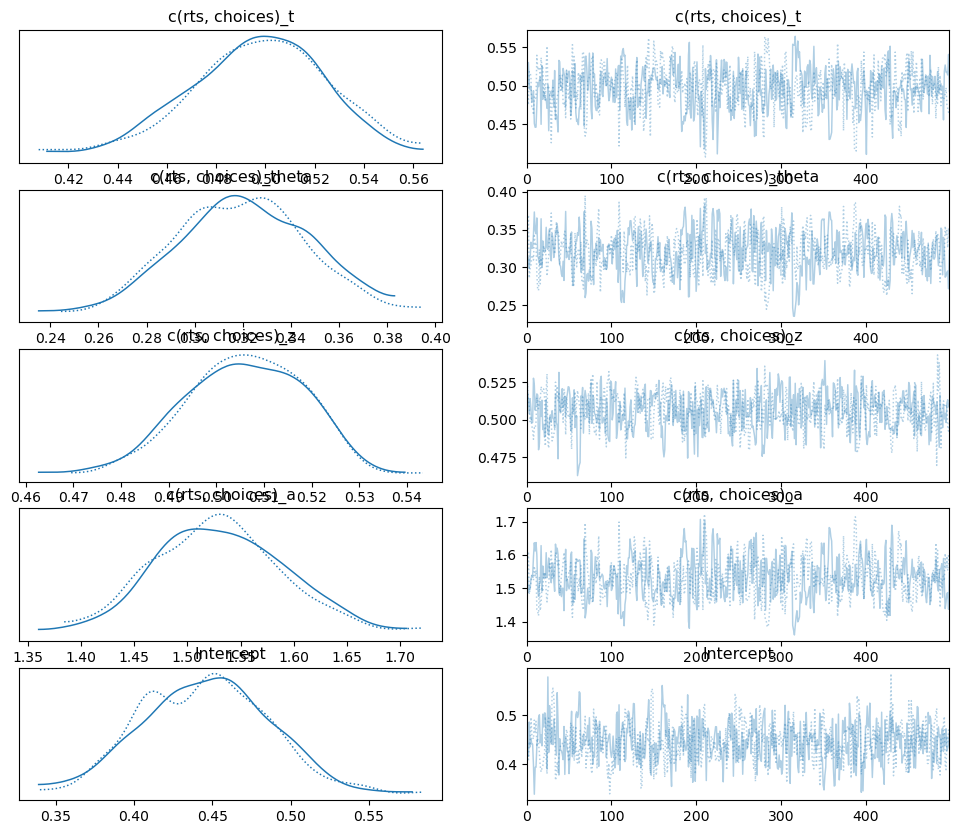

In [22]:
az.plot_trace(jax_bmb_lan)

#### Sampling with Pytensor from LAN distribution with pytensor backend

In [19]:
LAN_Likelihood_pytensor = bmb.Likelihood(
    "LAN_pytensor", params=["v", "a", "z", "t", "theta"], parent="v", dist=LAN_pytensor
)
# You don't need to pass the link function for all the parameters when it's a non-distributional model.
# But if you want to use predictor for that parameter, you do need a link function
LAN_Family_pytensor = bmb.Family(
    "LAN_pytensor",
    likelihood=LAN_Likelihood_pytensor,
    link={
        "v": "identity",
        "a": "identity",
        "z": "identity",
        "t": "identity",
        "theta": "identity",
    },
)
priors = {
    "Intercept": bmb.Prior("Uniform", lower=-3, upper=3, initval=0),
    "a": bmb.Prior("Uniform", lower=0.5, upper=5, initval=2),
    "z": bmb.Prior("Uniform", lower=0.1, upper=0.9, initval=0.5),
    "t": bmb.Prior("Uniform", lower=0, upper=1.9, initval=0.01),
    "theta": bmb.Prior("Uniform", lower=0, upper=1.9, initval=0.01),
}
bmb_lan_pytensor = bmb.Model(
    "c(rts,choices)  ~ 1", df_lan, family=LAN_Family_pytensor, priors=priors
)
bmb_lan_pytensor

       Formula: c(rts,choices)  ~ 1
        Family: LAN_pytensor
          Link: v = identity
  Observations: 1000
        Priors: 
    target = v
        Common-level effects
            Intercept ~ Uniform(lower: -3.0, upper: 3.0, initval: 0.0)
        
        Auxiliary parameters
            c(rts, choices)_theta ~ Uniform(lower: 0.0, upper: 1.899999976158142, initval:
                0.009999999776482582)
            c(rts, choices)_t ~ Uniform(lower: 0.0, upper: 1.899999976158142, initval: 0.009999999776482582)
            c(rts, choices)_z ~ Uniform(lower: 0.10000000149011612, upper: 0.8999999761581421, initval: 0.5)
            c(rts, choices)_a ~ Uniform(lower: 0.5, upper: 5.0, initval: 2.0)

In [25]:
pytensor_bmb_lan = bmb_lan_pytensor.fit(
    cores=2, draws=500, tune=500, mp_ctx="forkserver"
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [c(rts, choices)_theta, c(rts, choices)_t, c(rts, choices)_z, c(rts, choices)_a, Intercept]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 32 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [26]:
az.summary(pytensor_bmb_lan)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"c(rts, choices)_theta",0.339,0.026,0.292,0.389,0.001,0.001,334.0,486.0,1.02
"c(rts, choices)_t",0.500,0.027,0.449,0.547,0.002,0.001,164.0,277.0,1.03
"c(rts, choices)_z",0.523,0.013,0.501,0.548,0.001,0.000,407.0,640.0,1.00
"c(rts, choices)_a",1.562,0.060,1.452,1.681,0.003,0.002,321.0,453.0,1.02
Intercept,0.441,0.043,0.361,0.521,0.002,0.001,444.0,384.0,1.00


array([[<Axes: title={'center': 'c(rts, choices)_theta'}>,
        <Axes: title={'center': 'c(rts, choices)_theta'}>],
       [<Axes: title={'center': 'c(rts, choices)_t'}>,
        <Axes: title={'center': 'c(rts, choices)_t'}>],
       [<Axes: title={'center': 'c(rts, choices)_z'}>,
        <Axes: title={'center': 'c(rts, choices)_z'}>],
       [<Axes: title={'center': 'c(rts, choices)_a'}>,
        <Axes: title={'center': 'c(rts, choices)_a'}>],
       [<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>]], dtype=object)

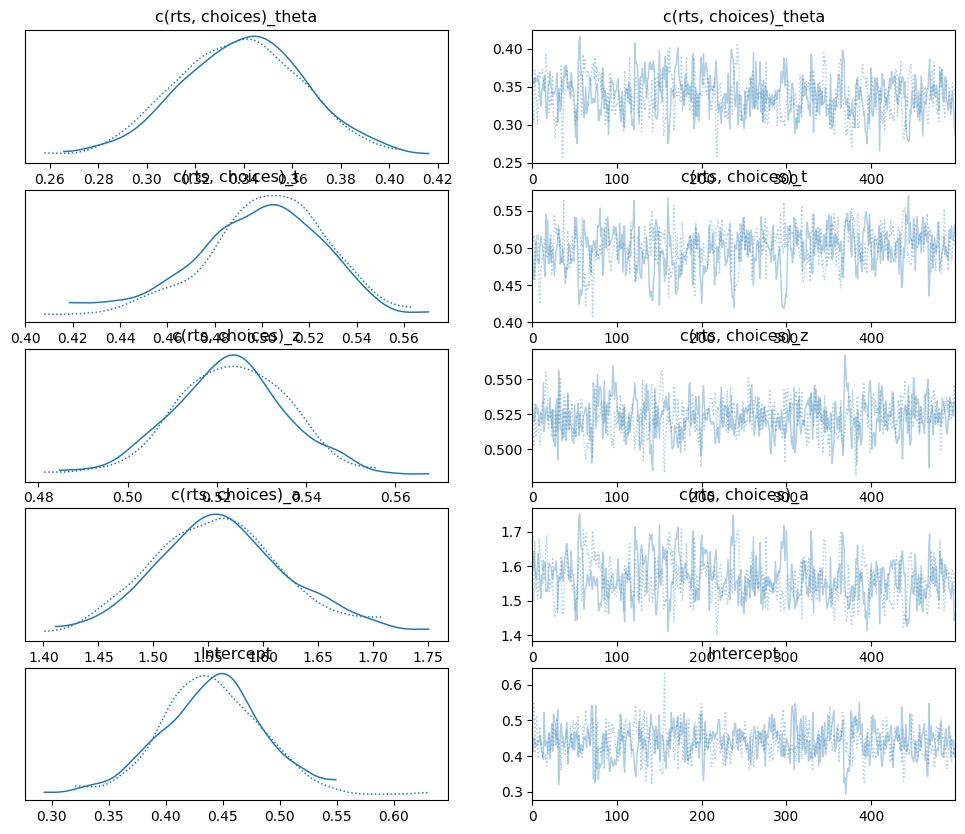

In [27]:
az.plot_trace(pytensor_bmb_lan)